# Neural Network from scratch for HandWritten Digit Recognition

## loading the dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')


# Reading The Train Set
train_images_file = open('train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

train_set = []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    train_set.append((image, label))


# Reading The Test Set
test_images_file = open('t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_set = []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))



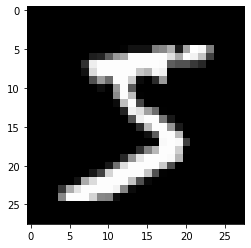

In [ ]:
# Plotting an image
show_image(train_set[0][0])
plt.show()

## Design Network Architecture

$a_1=sigmoid(w_0*a_0+b_0)$ 

$w_0=[16,784]$

$a_0=[784,1]$

$b_0=[16,1]$

$a_2=sigmoid(w_1*a_1+b_1)$ 

$w_1=[16,16]$

$a_1=[16,1]$

$b_1=[16,1]$

$a_3=sigmoid(w_2*a_2+b_2)$ 

$w_2=[10,16]$

$a_2=[16,1]$

$b_2=[10,1]$


## Feed Forward Test

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
W=[]
b=[]
w_0=np.random.randn(16,784)
b_0=np.zeros((16,1))
w_1=np.random.randn(16,16)
b_1=np.zeros((16,1))
w_2=np.random.randn(10,16)
b_2=np.zeros((10,1))
W=[w_0,w_1,w_2]
b=[b_0,b_1,b_2]


In [ ]:
labels=[]
for i in range(100):
    a_0=train_set[i][0]
    z_0=np.matmul(W[0],a_0)+b[0]
    a_1=sigmoid(z_0)
    z_1=np.matmul(W[1],a_1)+b[1]
    a_2=sigmoid(z_1)
    z_2=np.matmul(W[2],a_2)+b[2]
    a_3=sigmoid(z_2)    
    labels.append(np.argmax(a_3))


In [ ]:
train_set_labels=[np.argmax(i) for i in np.array(train_set)[:,1]]
accuracy=np.sum(np.array(labels)==np.array(train_set_labels[:100]))/100
print("accuracy = ",accuracy)

accuracy =  0.25


#### as we can see accuracy is only 25% as if it is totaly random

## backpropagation and training algorithm

In [ ]:
from tqdm import tqdm
import random
def sigmoid_derivative(x):
    return x*(1-x)
layers=3

def train_model(batch_size, lr,epochs,size,activation,activation_deriv):
    
    np.random.seed(0)
    W=[np.random.randn(16,784),np.random.randn(16,16),np.random.randn(10,16)]
    b=[np.zeros((16,1)),np.zeros((16,1)),np.zeros((10,1))]
    
    costs=[]
    t_set=train_set[:size]
    
    for x in tqdm(range(epochs)):
        random.shuffle(t_set)
        cost=0
        for batch in np.split(np.array(t_set),size/batch_size):
            #init to zero
            W_grad=[np.zeros((16,784)),np.zeros((16,16)),np.zeros((10,16))]
            b_grad=[np.zeros((16,1)),np.zeros((16,1)),np.zeros((10,1))]

            for t in batch:
                A=[t[0]]
                y=t[1]
                Z=[]
                #calculate output (forward propagate)
                for i in range(layers):
                    Z.append(np.matmul(W[i],A[i])+b[i])
                    A.append(activation(Z[i]))
                cost+=np.matmul((A[3]-y).T,(A[3]-y))

                #backpropagation
                #calculate deltas    
                d=[2*(A[3]-y)]
                d.insert(0,np.multiply(np.matmul(W[2].T,d[0]),activation_deriv(A[2])))
                d.insert(0,np.multiply(np.matmul(W[1].T,d[0]),activation_deriv(A[1])))


                #calculate derivatives
                dCdB = [np.zeros(b.shape) for b in b]
                dCdW = [np.zeros(w.shape) for w in W]
                for l in range(1, 4):
                    dCdB[-l] = d[-l]
                    dCdW[-l] = np.dot(d[-l], A[-l-1].T)  

                # sum for every image in batch
                for i in range(3):
                    b_grad = [b0+b1 for b0, b1 in zip(b_grad, dCdB)]
                    W_grad = [w0+w1 for w0, w1 in zip(W_grad, dCdW)]

            W_grad=np.divide(W_grad,batch_size)
            b_grad=np.divide(b_grad,batch_size)
            W=W-(lr*W_grad)
            b=b-(lr*b_grad)
        costs.append(cost[0][0]/size)
    return costs,W,b




# Model Evaluation

In [ ]:
def predict(W,b,in_set,out_set, activation):
    size=len(in_set)
    labels=[]
    for im in in_set:
        z_0=np.matmul(W[0],im)+b[0]
        a_1=activation(z_0)
        z_1=np.matmul(W[1],a_1)+b[1]
        a_2=activation(z_1)
        z_2=np.matmul(W[2],a_2)+b[2]
        a_3=activation(z_2)    
        labels.append(np.argmax(a_3))
    train_set_labels=[np.argmax(i) for i in np.array(out_set)]
    accuracy=np.sum(np.array(labels)==np.array(train_set_labels))
    print("accuracy = ",accuracy/size)

$batch size=10 \ \ learning rate =0.1 \ \ epochs=20 \ \ size=100$

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.06it/s]

accuracy =  0.89


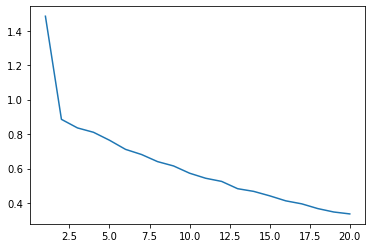

In [ ]:
batch_size=10
lr=0.1
epochs=20
size=100

costs,W,b=train_model(batch_size,lr,epochs,size,sigmoid,sigmoid_derivative)
predict(W,b,np.array(train_set[:size])[:,0],np.array(train_set[:size])[:,1],sigmoid)
plt.plot(np.arange(1,epochs+1,1),costs)


$batch size=10 \ \ learning rate =1 \ \ epochs=400 \ \ size=100$

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:21<00:00, 18.77it/s]

accuracy =  0.53


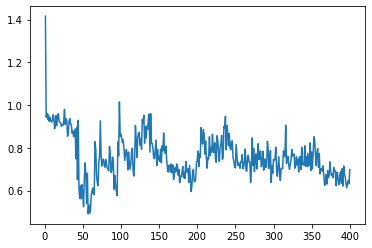

In [ ]:
batch_size=10
lr=1
epochs=400
size=100

costs,W,b=train_model(batch_size,lr,epochs,size,sigmoid,sigmoid_derivative)
predict(W,b,np.array(train_set[:size])[:,0],np.array(train_set[:size])[:,1],sigmoid)
plt.plot(np.arange(1,epochs+1,1),costs)


### training on all images in MNIST dataset

$batch size=50 \ \ learning rate =1 \ \ epochs=5 \ \ size=60000$

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.42s/it]


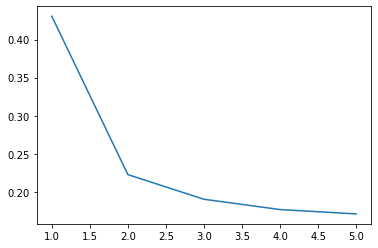

In [ ]:
batch_size=50
lr=1
epochs=5
size=60000
costs,W,b=train_model(batch_size,lr,epochs,size,sigmoid,sigmoid_derivative)
plt.plot(np.arange(1,epochs+1,1),costs)

### accuracy on training set

In [ ]:
predict(W,b,np.array(train_set)[:,0],np.array(train_set)[:,1],sigmoid)


accuracy =  0.8899


### accuracy on test set

In [ ]:
predict(W,b,np.array(test_set)[:,0],np.array(test_set)[:,1],sigmoid)

accuracy =  0.8878


# Additional Analysis

## 1- Adverserial Attack

In [ ]:
shifted=[]
for i in range(len(test_set)):
    shifted.append(np.vstack((np.zeros((112,1)),test_set[i][0][:-112])))
    

In [ ]:
predict(W,b,shifted,np.array(test_set)[:,1],sigmoid)


accuracy =  0.178


as we can see the accuracy of model dropped to 14% just by shifting images 4 columns to the right

## 2- Activation Functions

In [ ]:
def tanh(x):
    return np.tanh(x)
def tanh_deriv(x):
    return 1-np.tanh(x)**2

$batch size=50 \ \ learning rate =1 \ \ epochs=5 \ \ size=60000$

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.71s/it]


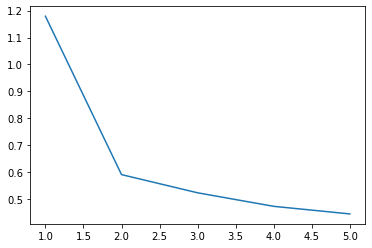

In [ ]:
batch_size=50
lr=0.1
epochs=5
size=60000

costs,W,b=train_model(batch_size,lr,epochs,size,tanh,tanh_deriv)
plt.plot(np.arange(1,epochs+1,1),costs)

In [ ]:
predict(W,b,np.array(test_set)[:,0],np.array(test_set)[:,1],tanh)

accuracy =  0.8097


## 3 - batch gradient descent

In [ ]:
def batch_gd(lr,epochs,size,activation,activation_deriv):
    
    np.random.seed(0)
    W=[np.random.randn(16,784),np.random.randn(16,16),np.random.randn(10,16)]
    b=[np.zeros((16,1)),np.zeros((16,1)),np.zeros((10,1))]
    
    costs=[]
    t_set=train_set[:size]
    
    for x in tqdm(range(epochs)):
        random.shuffle(t_set)
        cost=0
        #init to zero
        W_grad=[np.zeros((16,784)),np.zeros((16,16)),np.zeros((10,16))]
        b_grad=[np.zeros((16,1)),np.zeros((16,1)),np.zeros((10,1))]

        for t in np.array(t_set):
            A=[t[0]]
            y=t[1]
            Z=[]
            #calculate output (forward propagate)
            for i in range(layers):
                Z.append(np.matmul(W[i],A[i])+b[i])
                A.append(activation(Z[i]))
            cost+=np.matmul((A[3]-y).T,(A[3]-y))

            #backpropagation
            #calculate deltas    
            d=[2*(A[3]-y)]
            d.insert(0,np.multiply(np.matmul(W[2].T,d[0]),activation_deriv(A[2])))
            d.insert(0,np.multiply(np.matmul(W[1].T,d[0]),activation_deriv(A[1])))


            #calculate derivatives
            dCdB = [np.zeros(b.shape) for b in b]
            dCdW = [np.zeros(w.shape) for w in W]
            for l in range(1, 4):
                dCdB[-l] = d[-l]
                dCdW[-l] = np.dot(d[-l], A[-l-1].T)  

            # sum for every image in batch
            for i in range(3):
                b_grad = [b0+b1 for b0, b1 in zip(b_grad, dCdB)]
                W_grad = [w0+w1 for w0, w1 in zip(W_grad, dCdW)]

        W_grad=np.divide(W_grad,batch_size)
        b_grad=np.divide(b_grad,batch_size)
        W=W-(lr*W_grad)
        b=b-(lr*b_grad)
        costs.append(cost[0][0]/size)
    return costs,W,b


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.21it/s]


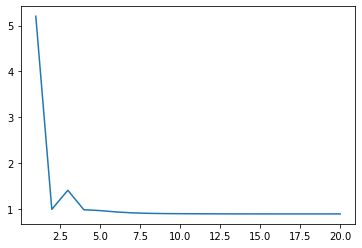

In [ ]:
lr=1
epochs=20
size=100

costs,W,b=batch_gd(lr,epochs,size,sigmoid,sigmoid_derivative)
plt.plot(np.arange(1,epochs+1,1),costs)

In [ ]:
predict(W,b,np.array(test_set)[:,0],np.array(test_set)[:,1],sigmoid) 

accuracy =  0.1136


دقت به شدت کاهش یافته(۱۰ درصد) و در چند ایپاک اول در مینیمم محل گیر می‌کند و خطا از ۱ کمتر نمی‌شود